In [208]:
%matplotlib inline

import os
import sys
import time

import SimpleITK as sitk
import numpy as np
import csv
from glob import glob
import pandas as pd
from skimage import measure
from skimage import transform
from scipy import ndimage
from matplotlib import pyplot as plt
import tensorflow as tf

import util
import image_aug
import luna_cropper
import luna_preprocess
import luna_enhance
import luna_unet_data
import luna_train_unet
import luna_unet_data2
import luna_train_unet2

reload(util);
reload(image_aug);
reload(luna_cropper);
reload(luna_preprocess);
reload(luna_enhance);
reload(luna_unet_data);
reload(luna_train_unet);
reload(luna_unet_data2);
reload(luna_train_unet2);

In [238]:
x, y = luna_train_unet2.load_data(['subset9'])

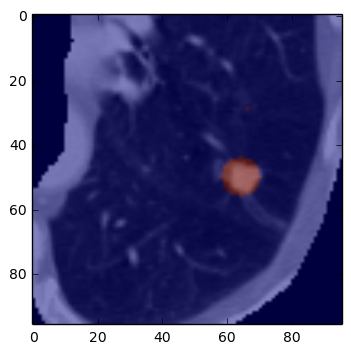

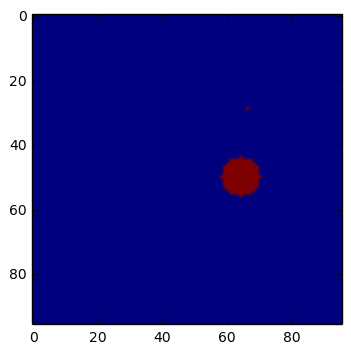

In [257]:
idx = np.random.randint(len(x))
plt.figure()
plot_image_and_mask(x[idx,0], y[idx,0])
plt.figure()
plt.imshow(y[idx, 0])

In [209]:
def sample_with_min_num_nodules(min_num_nodules, annt_df, subset):
    if subset is not None:
        annt_df[annt_df.file.str.contains(subset)]
    t = annt_df.groupby('file').count()
    t = list(t[t.seriesuid>=min_num_nodules].index)
    f = t[np.random.randint(len(t))]
    f_id = luna_preprocess.get_file_id(f)
    return f_id, annt_df[annt_df.file==f]
    

def plot_image_and_mask(image, mask):
    plt.imshow(image, cmap='gray')
    plt.imshow(mask, cmap='jet', alpha=0.5)

    
def rand_slice_image(masked_lung, all_nodule_mask):
    return luna_unet_data.slice_image(
        masked_lung, all_nodule_mask, np.random.randint(len(masked_lung)))


def slice_image_with_nodule(masked_lung, all_nodule_mask, nodule):
    nod_v_x, nod_v_y, nod_v_z, nod_v_d = nodule
    return luna_unet_data.slice_image(
        masked_lung, all_nodule_mask, nod_v_z)    
    

def pred_nodule_mask(image, model):
    ans = np.zeros_like(image)
    for i in range(5):
        for j in range(5):
            row_slice = slice(i * 96, (i + 1) * 96)
            col_slice = slice(j * 96, (j + 1) * 96)
            image_patch = np.reshape(image[row_slice, col_slice], [1, 1, 96, 96])
            image_patch = luna_train_unet2.normalize_images(image_patch)
            mask_patch = model.predict(image_patch)[0,0]
            ans[row_slice, col_slice] = mask_patch
    return ans

In [221]:
file_list = luna_preprocess.get_file_list()
file_dict = luna_preprocess.get_file_dict(file_list)
annt_df = luna_preprocess.get_annt_df(file_dict)

with tf.device('/cpu:0'):
    model = luna_train_unet2.get_unet()
model.load_weights('./unet2.hdf5')

In [222]:
f_id, f_annt = sample_with_min_num_nodules(5, annt_df, 'subset9')
print f_id

1.3.6.1.4.1.14519.5.2.1.6279.6001.192256506776434538421891524301


In [223]:
image = luna_preprocess.Image()
image.load(f_id)
masked_lung = image.masked_lung
all_nodule_mask = image._all_nodule_mask
nodules = image.get_v_nodules()
print '# of noduules = %d'%len(nodules)

# of noduules = 5


In [226]:
t_image, t_nodule_mask = slice_image_with_nodule(
    masked_lung, all_nodule_mask, nodules[2])
p_nodule_mask = pred_nodule_mask(t_image, model)
print luna_train_unet2.dice_coef_np(t_nodule_mask, p_nodule_mask)

0.00740127361618


In [236]:
t_image, t_nodule_mask = rand_slice_image(masked_lung, all_nodule_mask)
p_nodule_mask = pred_nodule_mask(t_image, model)
print luna_train_unet2.dice_coef_np(t_nodule_mask, p_nodule_mask)

0.0268264017892


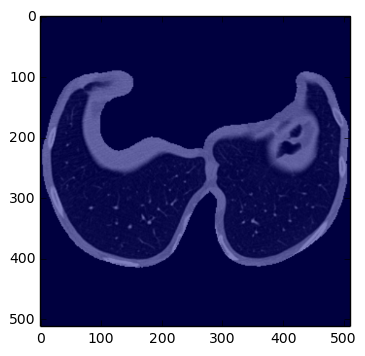

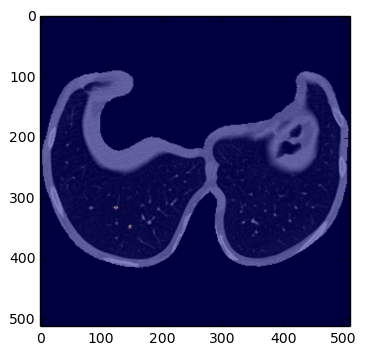

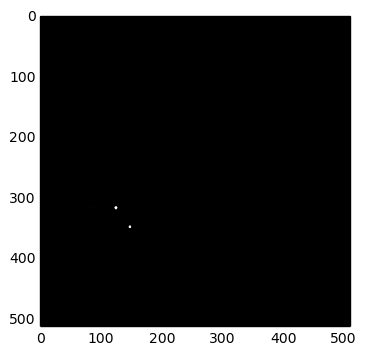

In [237]:
plt.figure()
plot_image_and_mask(t_image, t_nodule_mask)
plt.figure()
plot_image_and_mask(t_image, p_nodule_mask)
plt.figure()
plt.imshow(p_nodule_mask, cmap='gray')